# Path embeddings with FastPATH - Examples

In this notebook we will show you several examples of constructing path embeddings with the FastPATH algorithm.
The full documentation for the algorithm can be found [here](https://docs.google.com/document/d/1oCAz6ukn_r19H27ghxnGM_-UQP9rgYJRhLzNLHdQc8Y/edit#heading=h.ya70gurwgyt2).

## The Dataset

We will use a synthetic medical dataset containg `Patients`, `Encounters`, `Conditions`, `Observations` and more.
Using FastPATH we will construct (path) embeddings for patient journey in the dataset.
You need to replace the Neo4j URL and credentials to a database that contains the dataset.
Contact the GDS team if you're interested in that.

Below is the schema of the database:

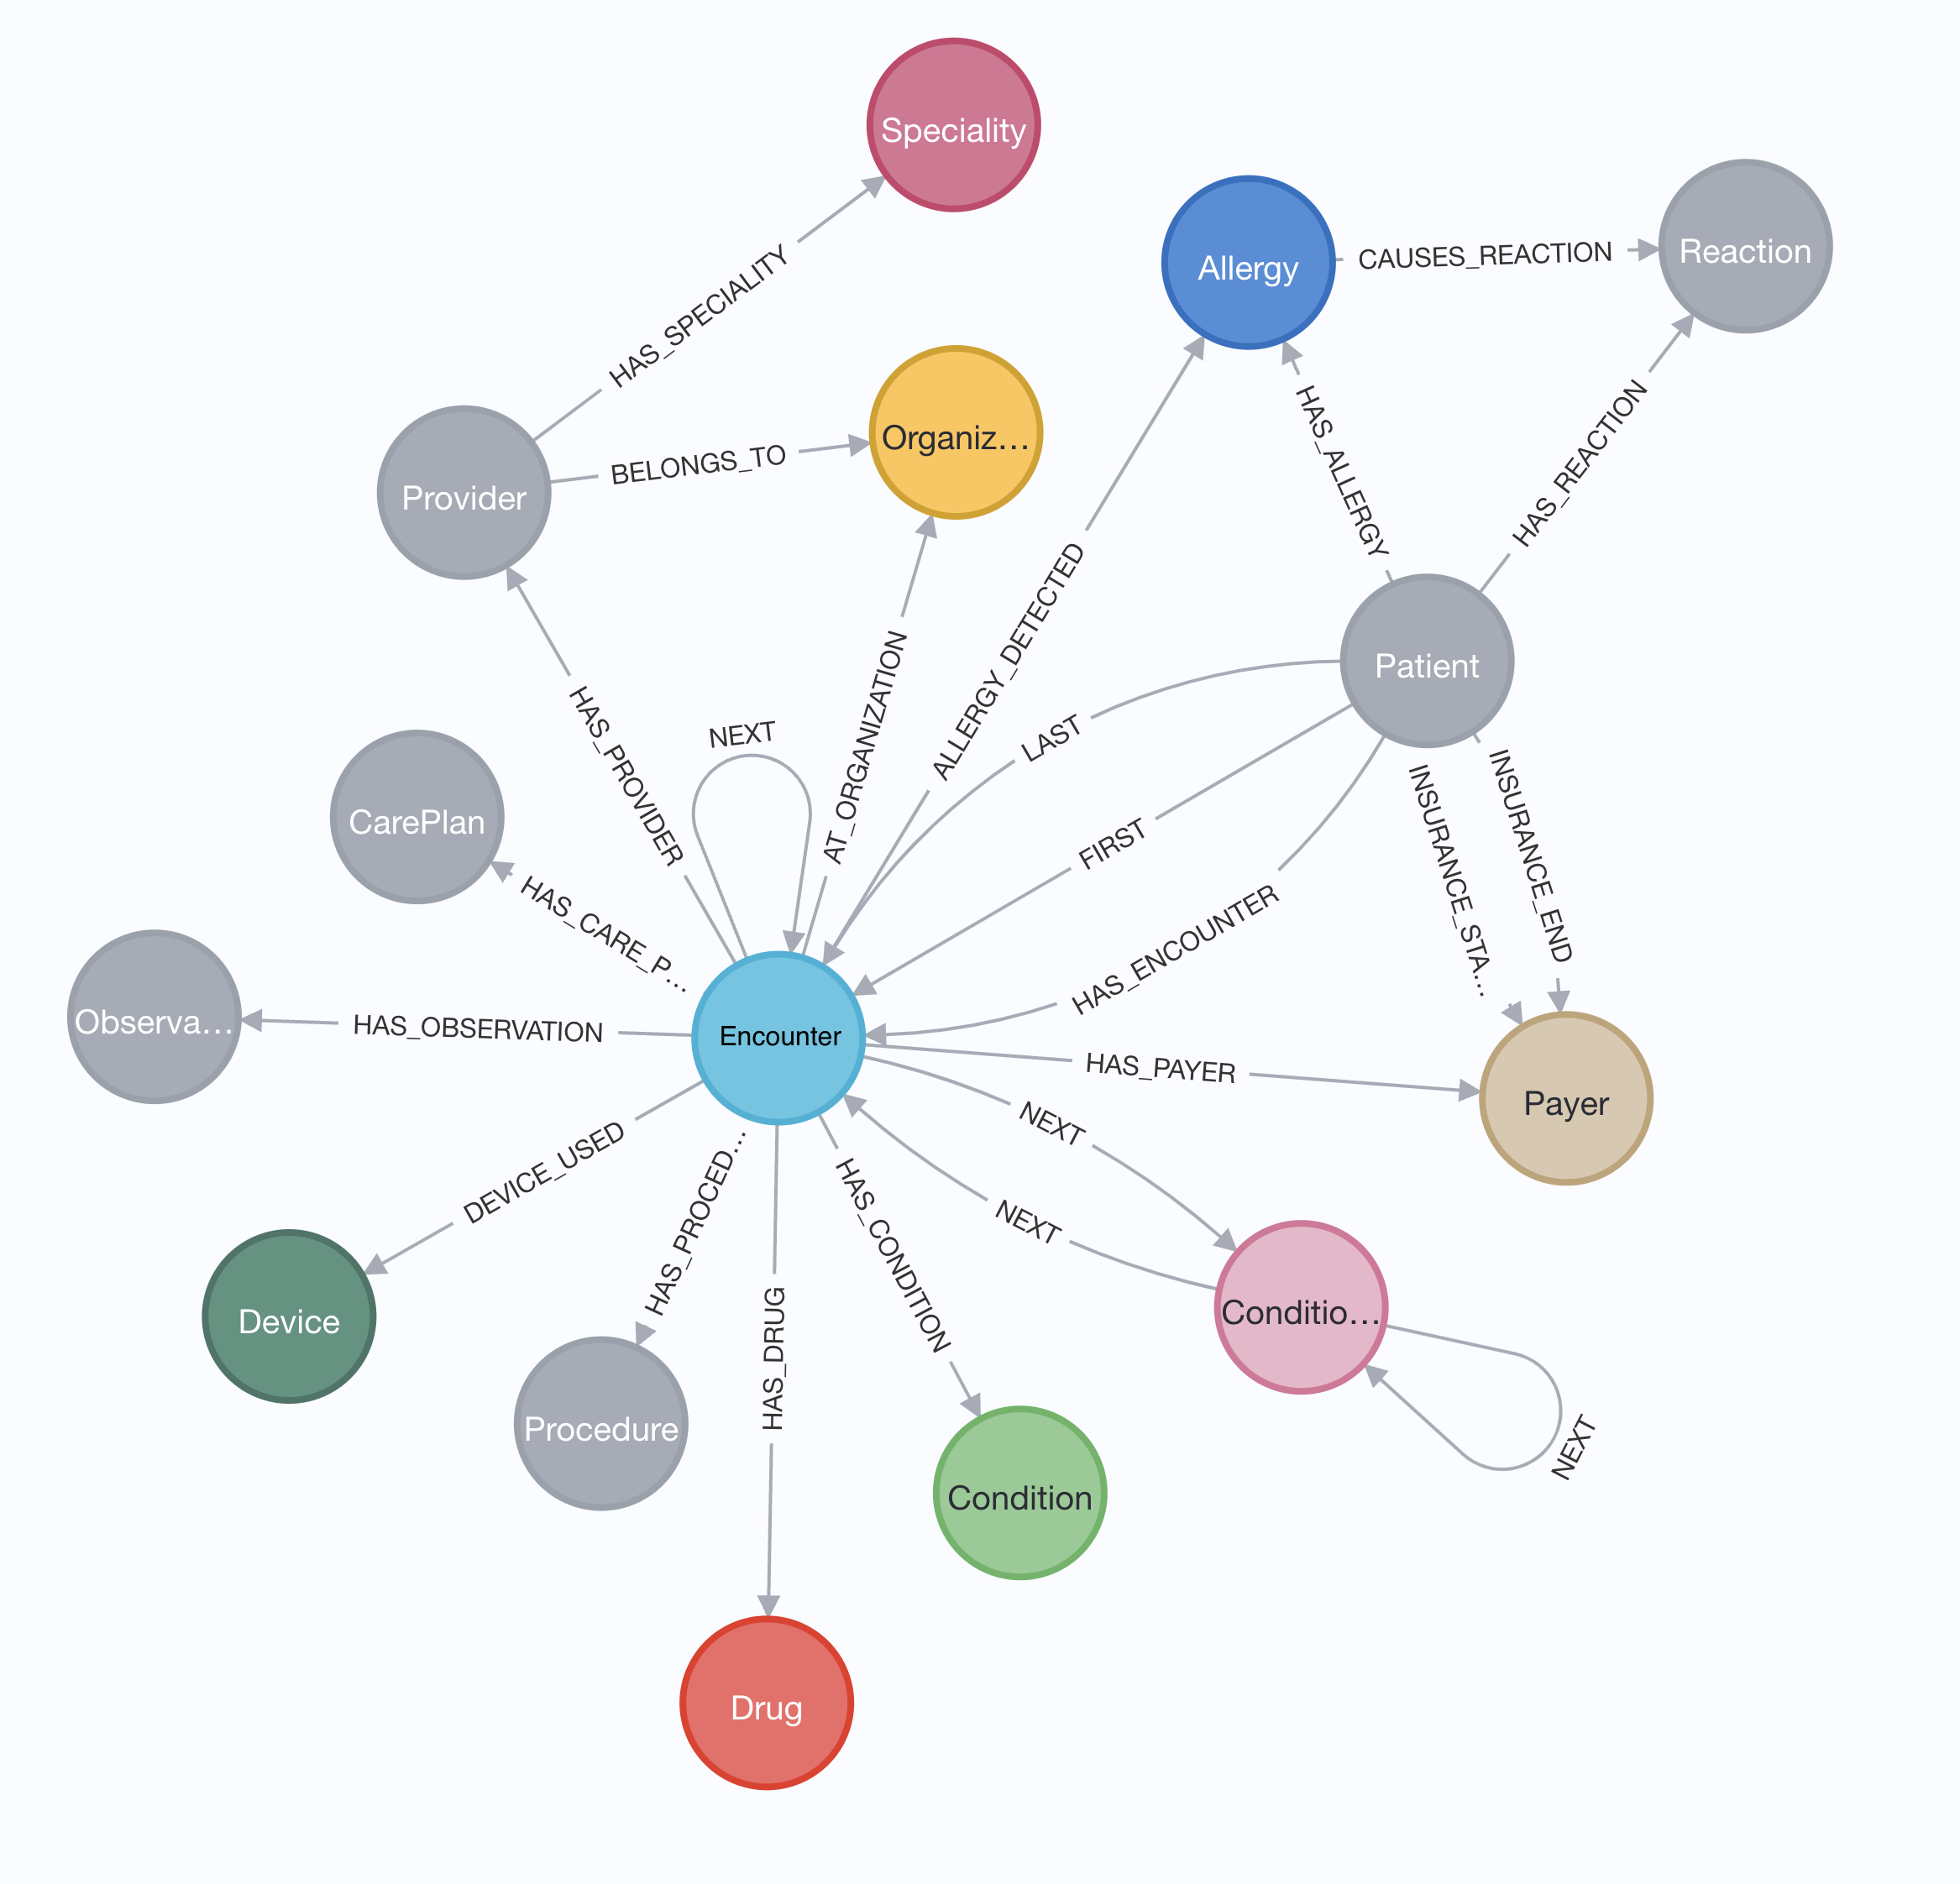

## Import and Setup

In [ ]:
from graphdatascience import GraphDataScience
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = [15, 10]

In [ ]:
gds = GraphDataScience(
    "neo4j+s://eddb7e19.databases.neo4j.io",
    auth=("neo4j", "Oz4oBK--Sx4byHjgHgJuMf5VqQncGHG9mbgpy44rQTU"),
    database="neo4j",
)
gds.set_compute_cluster_ip("localhost")

## Preprocessing

In order to make our dataset amenable to our analysis using FastPATH and downstream machine learning, we must augment it slightly.
This entails writing some additional node properties to the database with the Cypher code below.

**NOTE: Each preprocessing cell below must be run once, and only once.**

First we write a `has_diabetes` property (0 or 1) to each `Patient` node.
This will give us class labels that enable us to train a classification model on patient journeys later.

In [ ]:
gds.run_cypher("MATCH (p:Patient) SET p.has_diabetes=0")
gds.run_cypher(
    "MATCH (p:Patient)-[:HAS_ENCOUNTER]->(n:Encounter)-[:HAS_CONDITION]-(c:Condition) WHERE c.description='Diabetes' SET p.has_diabetes=1"
)

Then to each `Encounter` node, we write the number of days that has passed since 1 January 1970 (can be negative), based on the existing `start` node property.
We do this since the `start` property it already has is not an actual number, which is what the algorithm needs.
This is needed in the case where we don't rely on `NEXT` relationships for event timestamps, which is one of the examples below.

In [ ]:
gds.run_cypher(
    "MATCH (n:Encounter) WITH toInteger(datetime(n.start).epochseconds/(24 * 3600)) as days, n SET n.days=days"
)

Next we write two output time properties to each `Patient` based on the last `Encounter` before a diabetes diagnosis, or the last `Encounter` otherwise.
For the case where we are relying on the `days` node property on `Encounter`s (see above), the new `output_time` node property for `Patient`s will be equal to 1 + the `days` timestamp of their last encounter (before diabetes if they have it).
For the case where we are relying on `FIRST` and `NEXT` relationships to define the `Encounter`s belonging to a `Patient`, the new `output_time_stepwise` node property for `Patient`s will be equal to the number of encounters up to and including the last encounter (before diabetes if they have it).

With these properties we can specify the point in time for which we want the path embeddings for each `Patient` node.
I.e. the paths that is embedded will continue up to that point, but not longer.

In [ ]:
# Writing the `output_time` `Patient` node property
gds.run_cypher("MATCH (p:Patient)-[:LAST]->(n:Encounter) SET p.output_time=n.days+1")
gds.run_cypher(
    "MATCH (p:Patient)-[:HAS_ENCOUNTER]->(e1:Encounter)-[:NEXT]->(e2:Encounter)-[:HAS_CONDITION]->(c:Condition) WHERE c.description='Diabetes' SET p.output_time=e1.days + 1"
)

# Writing `output_time_stepwise` `Patient` node property
gds.run_cypher(
    "MATCH (p:Patient)-[:HAS_ENCOUNTER]->(e:Encounter) WHERE e.days <= p.output_time - 1 WITH p, count(*) as cc SET p.output_time_stepwise=cc"
)

Lastly we write the `class` of each `Encounter` as an integer property `intClass`.
Doing so enables us to use the class property as input to the algorithm, impacting the internal embeddings of `Encounter` nodes.

In [ ]:
gds.run_cypher(
    """
    MATCH (e:Encounter) with distinct e.class AS class
    WITH collect(class) as clss
    WITH apoc.map.fromLists(clss, range(0, size(clss) - 1)) as classMap
    MATCH (e:Encounter) SET e.intClass = classMap[e.class]
    """
)

## Projection with Timestamps

For the first examples, we rely on the `days` property of `Encounter` nodes for timestamp.
For this reason we don't need to project `FIRST` and `NEXT` relationships.

In [ ]:
try:
    G = gds.graph.get("medical")
    G.drop()
except:
    pass

G, _ = gds.graph.project(
    "medical",
    {
        "Patient": {"properties": ["output_time", "has_diabetes"]},
        "Encounter": {"properties": ["days", "intClass"]},
        "Observation": {"properties": []},
        "Payer": {"properties": []},
        "Provider": {"properties": []},
        "Organization": {"properties": []},
        "Speciality": {"properties": []},
        "Allergy": {"properties": []},
        "Reaction": {"properties": []},
        "Condition": {"properties": []},
        "Drug": {"properties": []},
        "Procedure": {"properties": []},
        "CarePlan": {"properties": []},
        "Device": {"properties": []},
        "ConditionDescription": {"properties": []},
    },
    [
        "HAS_OBSERVATION",
        "HAS_ENCOUNTER",
        "HAS_PROVIDER",
        "AT_ORGANIZATION",
        "HAS_PAYER",
        "HAS_SPECIALITY",
        "BELONGS_TO",
        "INSURANCE_START",
        "INSURANCE_END",
        "HAS_ALLERGY",
        "ALLERGY_DETECTED",
        "HAS_REACTION",
        "CAUSES_REACTION",
        "HAS_CONDITION",
        "HAS_DRUG",
        "HAS_PROCEDURE",
        "HAS_CARE_PLAN",
        "DEVICE_USED",
    ],
)

## FastRP Features

We should make use of the topological information we have around in `Encounter` node.
For example, what `Condition`s, `Drug`s, `Procedure`s, etc. (see schema above) are connected to it.
And perhaps one hop in the graph beyond that.
To do so, we make use of FastRP to create node embeddings.
Later we can input the node embeddings of the `Encounter` nodes to the FastPATH algorithm using the `event_features` parameter.

In [ ]:
gds.fastRP.mutate(
    G,
    embeddingDimension=256,
    mutateProperty="emb",
    iterationWeights=[1, 1],
    randomSeed=42,
)

## Preparation of machine learning and visualization of embeddings

Below we define a utility function that we can subsequently use to analyze the path embeddings we produce in each example below.
This function does three things:
1. Computes the average pairwise distances between embeddings of the different class combinations (no diabetes vs diabetes)
2. Plot the path embeddings in two dimensions with t-SNE
3. Train and evaluate a logistic regression diabetes classifier which takes path embeddings as input

**NOTE: You don't have to read or understand this function, but can think of it as a black box in the context of this notebook.**

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def explore(embeddings):

    # Compute pairwise distances between embeddings of healty<->healthy, sick<->sick and healthy<->sick.

    diabetes_by_nodeId = gds.graph.streamNodeProperties(G, ["has_diabetes"], ["Patient"]).set_index("nodeId")[
        ["propertyValue"]
    ]
    emb_and_diabetes = (
        embeddings[["nodeId", "embeddings"]]
        .set_index("nodeId")
        .merge(diabetes_by_nodeId, left_index=True, right_index=True)
    )
    healthy_embs = np.array(emb_and_diabetes[emb_and_diabetes.propertyValue == 0]["embeddings"].tolist())
    diabetes_embs = np.array(emb_and_diabetes[emb_and_diabetes.propertyValue == 1]["embeddings"].tolist())

    diabetes_distances = []
    for i in range(diabetes_embs.shape[0]):
        for j in range(i + 1, diabetes_embs.shape[0]):
            x1 = diabetes_embs[i, :]
            x2 = diabetes_embs[j, :]
            diabetes_distances.append(np.linalg.norm(x1 - x2))

    print(f"Avg diabetes<->diabetes L2-distances: {np.mean(diabetes_distances)}")

    healthy_distances = []
    for i in range(healthy_embs.shape[0]):
        for j in range(i + 1, healthy_embs.shape[0]):
            x1 = healthy_embs[i, :]
            x2 = healthy_embs[j, :]
            healthy_distances.append(np.linalg.norm(x1 - x2))

    print(f"Avg healthy<->healthy L2-distances: {np.mean(healthy_distances)}")

    mixed_distances = []
    for i in range(diabetes_embs.shape[0]):
        for j in range(healthy_embs.shape[0]):
            x1 = diabetes_embs[i, :]
            x2 = healthy_embs[j, :]
            mixed_distances.append(np.linalg.norm(x1 - x2))

    print(f"Avg healthy<->diabetes L2-distances: {np.mean(mixed_distances)}")

    # TSNE time

    X = np.array(emb_and_diabetes["embeddings"].tolist())
    y = emb_and_diabetes.propertyValue.to_numpy()
    tsne = TSNE(2)
    tsne_result = tsne.fit_transform(X)
    tsne_result_df = pd.DataFrame({"tsne_1": tsne_result[:, 0], "tsne_2": tsne_result[:, 1], "label": y})
    fig, ax = plt.subplots(1)
    sns.scatterplot(x="tsne_1", y="tsne_2", hue="label", data=tsne_result_df, ax=ax, s=10)
    lim = (tsne_result.min() - 5, tsne_result.max() + 5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect("equal")
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

    # Train evaluate diabetes classifier :)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_f1_score = f1_score(y_train, y_train_pred, average="macro")
    test_f1_score = f1_score(y_test, y_test_pred, average="macro")

    print("Diabetes classifier scores:")
    print(f"Train set f1: {train_f1_score}")
    print(f"Test set f1: {test_f1_score}")

## Examples with timestamp node properties

In the following few examples we will let the `days` node property on `Encounter` nodes dictate when an encounter has occured.

### Global output time

To use a single fixed output time, you can either
* Use the algorithm parameter `output_times` (and optionally use subgraph filtering to run only up to a certain time), or
* Use Cypher to write a output time property to the `Patient` nodes holding a fixed timestamp, and then provide it as `output_time_property`

Here we will use the first option.

Note that we are also using the FastRP embeddings for `Encounter` nodes as input features to the events (encounters).

In [ ]:
# try:
gds.graph.nodeProperties.drop(G, ["embeddings"], node_labels=["Patient"])
# except:
# pass

gds.fastpath.mutate(
    G,
    base_node_label="Patient",
    event_node_label="Encounter",
    event_features="emb",
    time_node_property="days",
    dimension=256,
    num_elapsed_times=100,
    output_time=365 * 50,  # 50 years
    max_elapsed_time=365 * 10,  # 10 years
    smoothing_rate=0.004,
    smoothing_window=3,
    decay_factor=1e-5,
    random_seed=42,
)

In [ ]:
embeddings = gds.graph.nodeProperties.stream(G, ["embeddings"], node_labels=["Patient"], separate_property_columns=True)
print(embeddings)
explore(embeddings)

## Example with individual output time

In [ ]:
try:
    gds.graph.nodeProperties.drop(G, ["embeddings"], node_labels=["Patient"])
except:
    pass

embeddings = gds.fastpath.mutate(
    G,
    base_node_label="Patient",
    event_node_label="Encounter",
    event_features="emb",
    time_node_property="days",
    dimension=256,
    num_elapsed_times=100,
    output_time_property="output_time",
    max_elapsed_time=365 * 10,
    smoothing_rate=0.004,
    smoothing_window=3,
    decay_factor=1e-4,
    random_seed=42,
)

In [ ]:
embeddings = gds.graph.nodeProperties.stream(G, ["embeddings"], node_labels=["Patient"], separate_property_columns=True)
print(embeddings)
explore(embeddings)

# Example with categorical event property and input event vectors
As the type (class) of encounter may be important to characterize patient journeys and to classify diabetes, we 'intClass' as a categorical event property.

In [ ]:
embeddings = gds.fastpath.mutate(
    G,
    base_node_label="Patient",
    event_node_label="Encounter",
    event_features="emb",
    time_node_property="days",
    categorical_event_properties=["intClass"],
    dimension=256,
    num_elapsed_times=100,
    output_time_property="output_time",
    max_elapsed_time=365 * 10,
    smoothing_rate=0.004,
    smoothing_window=3,
    decay_factor=1e-4,
    random_seed=42,
)

In [ ]:
embeddings = gds.graph.nodeProperties.stream(G, ["embeddings"], node_labels=["Patient"], separate_property_columns=True)
print(embeddings)
explore(embeddings)

# Example with context nodes and input event vectors
As the history of drugs may be important to characterize patient journeys and to classify diabetes, we add 'Drug' as a context_node_label.

In [ ]:
embeddings = gds.fastpath.stream(
    G,
    base_node_label="Patient",
    context_node_label="Drug",
    event_node_label="Encounter",
    event_features="emb",
    time_node_property="days",
    dimension=256,
    # num_elapsed_times=100,
    num_elapsed_times=1,
    output_time_property="output_time",
    # max_elapsed_time=365 * 10,
    max_elapsed_time=1,
    smoothing_rate=0.004,
    smoothing_window=0,
    # smoothing_window=3,
    decay_factor=1e-4,
    random_seed=43,
)

In [ ]:
embeddings = gds.graph.nodeProperties.stream(G, ["embeddings"], node_labels=["Patient"], separate_property_columns=True)
print(embeddings)
explore(embeddings)

# Example with next and first relationship schema
We will now repeat one of the previous examples but use a different schema for the paths.
In this case it will give the same graph and embeddings, but the example is useful for illustrating the use of the next-first schema.

In [ ]:
try:
    G = gds.graph.get("medical")
    G.drop()
except:
    pass

G, _ = gds.graph.project(
    "medical",
    {
        "Patient": {"properties": ["output_time", "output_time_stepwise", "has_diabetes"]},
        "Encounter": {"properties": ["days", "intClass"]},
        "Observation": {"properties": []},
        "Payer": {"properties": []},
        "Provider": {"properties": []},
        "Organization": {"properties": []},
        "Speciality": {"properties": []},
        "Allergy": {"properties": []},
        "Reaction": {"properties": []},
        "Condition": {"properties": []},
        "Drug": {"properties": []},
        "Procedure": {"properties": []},
        "CarePlan": {"properties": []},
        "Device": {"properties": []},
        "ConditionDescription": {"properties": []},
    },
    [
        "HAS_OBSERVATION",
        "NEXT",
        "FIRST",
        "HAS_PROVIDER",
        "AT_ORGANIZATION",
        "HAS_PAYER",
        "HAS_SPECIALITY",
        "BELONGS_TO",
        "INSURANCE_START",
        "INSURANCE_END",
        "HAS_ALLERGY",
        "ALLERGY_DETECTED",
        "HAS_REACTION",
        "CAUSES_REACTION",
        "HAS_CONDITION",
        "HAS_DRUG",
        "HAS_PROCEDURE",
        "HAS_CARE_PLAN",
        "DEVICE_USED",
    ],
)

In [ ]:
gds.fastRP.mutate(
    G,
    embeddingDimension=256,
    mutateProperty="emb",
    iterationWeights=[1, 1],
    randomSeed=42,
    relationshipTypes=[
        "HAS_OBSERVATION",
        "HAS_PROVIDER",
        "AT_ORGANIZATION",
        "HAS_PAYER",
        "HAS_SPECIALITY",
        "BELONGS_TO",
        "INSURANCE_START",
        "INSURANCE_END",
        "HAS_ALLERGY",
        "ALLERGY_DETECTED",
        "HAS_REACTION",
        "CAUSES_REACTION",
        "HAS_CONDITION",
        "HAS_DRUG",
        "HAS_PROCEDURE",
        "HAS_CARE_PLAN",
        "DEVICE_USED",
    ],
)

In [ ]:
embeddings = gds.fastpath.stream(
    G,
    base_node_label="Patient",
    context_node_label="Drug",
    event_node_label="Encounter",
    event_features="emb",
    next_relationship_type="NEXT",
    first_relationship_type="FIRST",
    time_node_property="days",
    dimension=256,
    num_elapsed_times=100,
    output_time_property="output_time",
    max_elapsed_time=365 * 10,
    smoothing_rate=0.003701319681951021,
    smoothing_window=3,
    decay_factor=8.232744730741784e-05,
    random_seed=43,
)

In [ ]:
explore(embeddings, "embeddings")